In [30]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import itertools

from IPython.display import display, HTML

In [31]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_absolute_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_relative_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_sampledata_5in10.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [32]:
'''Set sample names as index and shuffle data'''
index = target.Lake[target.Lake == 'Muskegon'].index

data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [33]:
hna_scores = pd.read_csv('Scores/hnascores_otus_5seq10_clr_Muskegon.csv', index_col=0)

''' Log-Ratio analyses '''
otus = list(data_rel.columns)
data_rel_repl = composition.multiplicative_replacement(data_rel.loc[:,otus])
data_rel_clr = pd.DataFrame(composition.clr(data_rel_repl), columns=otus, index=index)

In [34]:
#Remove outlier samples:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [46]:
kendall_abs = np.zeros(hna_scores.shape[0])
p_kendall_abs = np.zeros(hna_scores.shape[0])
kendall_rel = np.zeros(hna_scores.shape[0])
p_kendall_rel = np.zeros(hna_scores.shape[0])
kendall_clr = np.zeros(hna_scores.shape[0])
p_kendall_clr = np.zeros(hna_scores.shape[0])

i=0
for otu in hna_scores.index:
    kendall_clr[i], p_kendall_clr[i] = kendalltau(data_rel_clr.loc[index_prod,otu],prod)
    i+=1
    
hna_scores['kendall_prod_abs'] = kendall_abs
hna_scores['p_kendall_prod_abs'] = p_kendall_abs
hna_scores['kendall_prod_rel'] = kendall_rel
hna_scores['p_kendall_prod_rel'] = p_kendall_rel
hna_scores['kendall_prod_clr'] = kendall_clr
hna_scores['p_kendall_prod_clr'] = p_kendall_clr

In [36]:
display(hna_scores.head(5))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,kendall,p_kendall,kendall_prod_abs,p_kendall_prod_abs,kendall_prod_rel,p_kendall_prod_rel,kendall_prod_clr,p_kendall_prod_clr
Otu000029,0.618,61707.245500,1.200677,0.008522,0.878843,0.259651,2.860222e-03,-0.073684,0.649671,-0.148150,0.363140,-0.115789,0.475367
Otu000173,0.588,19183.863568,1.389539,0.002640,1.213961,0.501851,8.199569e-09,0.284211,0.079775,0.273507,0.096638,0.284211,0.079775
Otu000038,0.554,51754.310417,1.307713,0.006845,1.065805,0.279746,1.312698e-03,0.073684,0.649671,-0.063493,0.696727,-0.042105,0.795208
Otu000242,0.506,4279.004838,1.331277,0.000632,1.054300,0.195135,2.500431e-02,0.226914,0.162763,0.099062,0.569147,0.063158,0.697031
Otu000088,0.506,7070.539859,1.127830,0.001325,1.105117,-0.240613,5.714879e-03,0.237468,0.144081,0.128353,0.447041,0.168421,0.299169


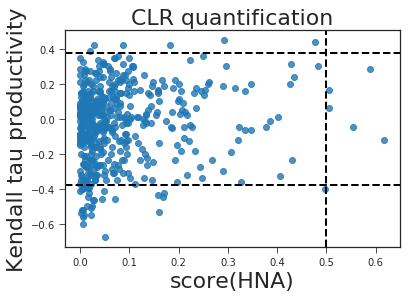

In [47]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_clr'], fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR quantification', size=22)
plt.show()

In [38]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_clr'] > 0.377)].index
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_rel.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Relative abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

In [39]:
kendall_sum_clr = np.zeros(hna_scores.shape[0])
p_kendall_sum_clr = np.zeros(hna_scores.shape[0])
kendall_sum_clr_thr = np.zeros(hna_scores.shape[0])
p_kendall_sum_clr_thr = np.zeros(hna_scores.shape[0])

sum_clr = np.zeros(len(index_prod))
sum_clr_thr = np.zeros(len(index_prod))

i=0
thr = 0
for otu in hna_scores.index:
    sum_clr += data_rel_clr.loc[index_prod,otu]
    sum_clr_thr += data_rel_clr.loc[index_prod,otu]
    kendall_sum_clr[i], p_kendall_sum_clr[i] = kendalltau(sum_clr,prod)
    kendall_sum_clr_thr[i], p_kendall_sum_clr_thr[i] = kendalltau(sum_clr_thr,prod)
    if kendall_sum_clr_thr[i] > thr: 
        thr = kendall_sum_clr_thr[i]
    else: 
        sum_clr_thr -= data_rel_clr.loc[index_prod,otu]
        kendall_sum_clr_thr[i] = 0
    i+=1

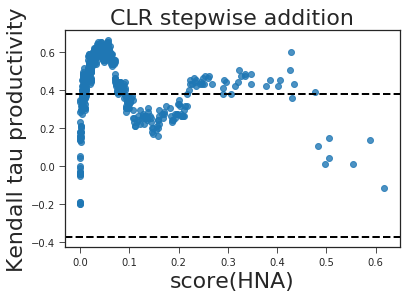

In [40]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_clr, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR stepwise addition', size=22)
plt.show()

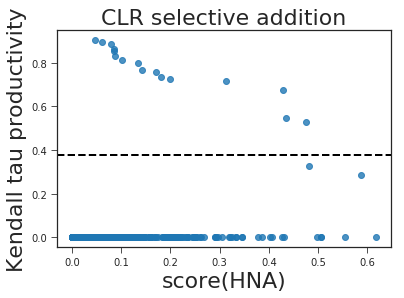

In [41]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_clr_thr, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR selective addition', size=22)
plt.show()

In [42]:
otus_prod_hna = hna_scores.loc[kendall_sum_clr_thr > 0,:].index
print('OTUs part of productivity correlation pool based on HNA:' + str(otus_prod_hna))

OTUs part of productivity correlation pool based on HNA:Index(['Otu000173', 'Otu000264', 'Otu000614', 'Otu001267', 'Otu000246',
       'Otu000060', 'Otu000043', 'Otu000469', 'Otu000022', 'Otu000409',
       'Otu000194', 'Otu000283', 'Otu000407', 'Otu000716', 'Otu000917',
       'Otu000074', 'Otu000212', 'Otu000340'],
      dtype='object')


In [43]:
lna_scores = pd.read_csv('Scores/lnascores_otus_5seq10_clr_Muskegon.csv', index_col=0)

kendall_sum_clr = np.zeros(lna_scores.shape[0])
p_kendall_sum_clr = np.zeros(lna_scores.shape[0])
kendall_sum_clr_thr = np.zeros(lna_scores.shape[0])
p_kendall_sum_clr_thr = np.zeros(lna_scores.shape[0])

sum_clr = np.zeros(len(index_prod))
sum_clr_thr = np.zeros(len(index_prod))

i=0
thr = 0
for otu in lna_scores.index:
    sum_clr += data_rel_clr.loc[index_prod,otu]
    sum_clr_thr += data_rel_clr.loc[index_prod,otu]
    kendall_sum_clr[i], p_kendall_sum_clr[i] = kendalltau(sum_clr,prod)
    kendall_sum_clr_thr[i], p_kendall_sum_clr_thr[i] = kendalltau(sum_clr_thr,prod)
    if kendall_sum_clr_thr[i] > thr: 
        thr = kendall_sum_clr_thr[i]
    else: 
        sum_clr_thr -= data_rel_clr.loc[index_prod,otu]
        kendall_sum_clr_thr[i] = 0
    i+=1

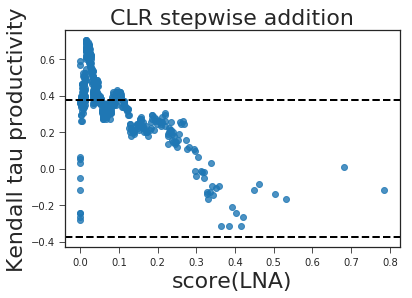

In [44]:
plt.figure()
sns.regplot(x=lna_scores.loc[:,'score'],y=kendall_sum_clr, fit_reg=False)
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR stepwise addition', size=22)
plt.show()

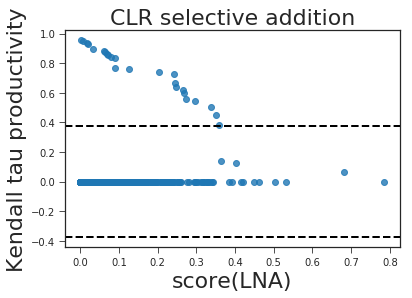

In [45]:
plt.figure()
sns.regplot(x=lna_scores.loc[:,'score'],y=kendall_sum_clr_thr, fit_reg=False)
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR selective addition', size=22)
plt.show()